In [1]:
from __future__ import print_function

import os
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from source.DataFrameSelector import DataFrameSelector

from datetime import datetime, timezone

from tqdm import tqdm
import torch
import torch.nn as nn

In [2]:
DATA_PATH = os.path.join("..", "data")

def load_csv(filename, path=DATA_PATH):
    return pd.read_csv(os.path.join(path, filename))

def to_utc_datetime(df, column="time"):
    df[column] = df.apply(lambda row: datetime.strptime(row[column], "%Y-%m-%d %H:%M:%S%z").astimezone(timezone.utc), axis=1)
    return df

def get_price():
    e_data = load_csv("energy_dataset.csv")
    return e_data[["time", "price day ahead", "total load actual", "price"]].rename(
        columns={"price day ahead": "TSO_price_forecast",
                 "total load actual": "load"})

def add_weather_data(df):
    w_data = load_csv("weather_features.csv").drop(columns=["weather_id", "weather_icon", "temp_min", "temp_max"])
    w_data = w_data.join(other=df.set_index("time"), on="time").drop_duplicates(subset=["time", "city_name"])
    return w_data.reset_index(drop=True)

In [185]:
data = to_utc_datetime(add_weather_data(get_price()))
data.drop(columns=["weather_main", "weather_description", "TSO_price_forecast"], inplace=True)
data.fillna(method="ffill", inplace=True)
data = data.drop(columns=["city_name"]).groupby(by=["time"]).mean()

In [186]:
#differencing
data["price_"] = data["price"]
data["price"] = data["price"].diff()

target_year = 2018
train_data = data.loc[data.index.year != target_year]
train_data = train_data.drop(columns="price_")
train_data = train_data.iloc[1:]
test_data = data.loc[data.index.year == target_year]
test_data = test_data.drop(columns="price_")

In [99]:
train_data.isna().values.any()

False

In [183]:
target_year = 2018
train_data = data.loc[data.index.year != target_year]
test_data = data.loc[data.index.year == target_year]

In [77]:
scaler_y = MinMaxScaler()
scaler_y.fit(train_data["price"].values.reshape(-1, 1))

scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#train_data_scaled = torch.FloatTensor(train_data_scaled).to(device)

In [121]:
def create_input_output_sequence(input_data, seq_len, multivar=False):
    # if multivar: target column has to be the last column
    X = []
    y = []
    L = len(input_data)
    for i in range(L-seq_len):
        train_seq = input_data[i:i+seq_len]
        train_label = input_data[i+seq_len:i+seq_len+1]
        if multivar:
            train_label = train_label[:, -1]
        X.append(train_seq)
        y.append(train_label)
    X=torch.FloatTensor(X).to(device)
    y=torch.FloatTensor(y).to(device)
    return X, y

X, y = create_input_output_sequence(train_data_scaled, 24*7, True)

In [122]:
X[0]
#print(X[2][-1])
#print(y[1])
#train_data_scaled[0]

tensor([[0.0154, 0.0010, 0.7609,  ..., 0.0000, 0.2760, 0.4230],
        [0.0042, 0.0010, 0.7554,  ..., 0.0000, 0.2043, 0.4237],
        [0.0040, 0.0010, 0.7554,  ..., 0.0000, 0.1412, 0.3603],
        ...,
        [0.1332, 0.0010, 0.7989,  ..., 0.1087, 0.6379, 0.3097],
        [0.1147, 0.0010, 0.7989,  ..., 0.1478, 0.5413, 0.3882],
        [0.1255, 0.0010, 0.8016,  ..., 0.1478, 0.3807, 0.4116]],
       device='cuda:0')

In [37]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, batch_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,batch_size,self.hidden_layer_size).to(device),
                            torch.zeros(1,batch_size,self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(self.hidden_cell[0])
        return predictions[-1]

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # One time step
        out, (hn, cn) = self.lstm(x.view(len(x) ,1, -1), (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

In [123]:
mini_batch = 100
model = LSTM(input_size=11,batch_size=mini_batch)
#model = LSTMModel(input_dim=11, hidden_dim=100, layer_dim=2, output_dim=1)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)

LSTM(
  (lstm): LSTM(11, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [124]:
epochs = 1000

for i in range(epochs):
    with torch.autograd.detect_anomaly():
        idx = np.random.choice(X.shape[0], mini_batch, replace=False)
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, mini_batch, model.hidden_layer_size).to(device),
                             torch.zeros(1, mini_batch, model.hidden_layer_size).to(device))
        y_pred = model(X[idx])
        single_loss = loss(y_pred, y[idx])
        single_loss.backward()
        optimizer.step()

        if i%5 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.17384781
epoch:   6 loss: 0.16121028
epoch:  11 loss: 0.14949268
epoch:  16 loss: 0.13019384
epoch:  21 loss: 0.11777828
epoch:  26 loss: 0.10615817
epoch:  31 loss: 0.09967572
epoch:  36 loss: 0.08094903
epoch:  41 loss: 0.08024263
epoch:  46 loss: 0.06146123
epoch:  51 loss: 0.05624681
epoch:  56 loss: 0.04951898
epoch:  61 loss: 0.03331634
epoch:  66 loss: 0.02774880
epoch:  71 loss: 0.01636568
epoch:  76 loss: 0.00977111
epoch:  81 loss: 0.00773009
epoch:  86 loss: 0.00422819
epoch:  91 loss: 0.00714806
epoch:  96 loss: 0.00431438
epoch: 101 loss: 0.00424183
epoch: 106 loss: 0.00378791
epoch: 111 loss: 0.00501994
epoch: 116 loss: 0.00592082
epoch: 121 loss: 0.00484592
epoch: 126 loss: 0.00362127
epoch: 131 loss: 0.00475854
epoch: 136 loss: 0.00468818
epoch: 141 loss: 0.00546384
epoch: 146 loss: 0.00407012
epoch: 151 loss: 0.00382855
epoch: 156 loss: 0.00365170
epoch: 161 loss: 0.00400353
epoch: 166 loss: 0.00454931
epoch: 171 loss: 0.00354872
epoch: 176 loss: 0.0

C:\Users\Andre\anaconda3\envs\Forecast\lib\site-packages\torch\autograd\anomaly_mode.py:70: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  warnings.warn('Anomaly Detection has been enabled. '


In [194]:
window = 24*7
test_inputs = train_data_scaled[-window:].tolist()
prediction = []
for i in tqdm(range(len(test_data))):
    seq = torch.FloatTensor(test_inputs[-window:]).to(device)
    #print(seq.unsqueeze_(0).size())
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                             torch.zeros(1, 1, model.hidden_layer_size).to(device))
        output = model(seq.unsqueeze_(0))
        prediction.append(output)
        next_input = scaler.transform(test_data.iloc[i].values.reshape(1, -1)).reshape(-1)
        #next_input = next_input + (np.append(np.random.normal(0, 0.1, 10), 0))         # noise
        #next_input[-1] = output                                                        # prediction instead of real value
        test_inputs.append(next_input)

prediction = np.array(prediction)
prediction_df = test_data.assign(prediction=scaler_y.inverse_transform(prediction.reshape(-1, 1)).reshape(-1)).reset_index()

100%|██████████| 8759/8759 [00:25<00:00, 339.59it/s]


In [36]:
print("absolute difference to prediction at t-1 %f" % prediction_df["prediction"].diff().abs().mean())
print("absolute difference to price at t-1 %f" % prediction_df["price"].diff().abs().mean())

absolute difference to prediction at t-1 2.326914
absolute difference to price at t-1 2.258744


In [50]:
seq_len = 24*7
prediction_len = 24*7
test_data_scaled = scaler.transform(test_data)
test_inputs = np.vstack((train_data_scaled[-seq_len:].tolist(), test_data_scaled)).tolist()

def rolling_forecast(seq, feature_data):
    predictions = []
    for i in range(feature_data.shape[0]):
        with torch.no_grad():
            model_input = torch.FloatTensor(seq[i:]).to(device)
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                                 torch.zeros(1, 1, model.hidden_layer_size).to(device))
            output = model(model_input.unsqueeze_(0))
            predictions.append(output)
            seq.append(feature_data[i])
            seq[-1][-1] = output
    return predictions

prediction = []
for i in range(len(test_data) - prediction_len):
    seq = copy.deepcopy(test_inputs[i:i+seq_len])
    seq_f = test_data_scaled[i:i+prediction_len]
    prediction.append(rolling_forecast(seq, seq_f))

prediction = np.array(prediction)
prediction.shape

KeyboardInterrupt: 

In [18]:
f_o=23#*7-1 # offset into the future: 0 next hour, 1 predeciton of next hour +1
#prediction_df = test_data[f_o:prediction.shape[0]+f_o].assign(prediction=scaler_y.inverse_transform(prediction[:,f_o].reshape(-1, 1)).reshape(-1)).reset_index()
prediction_df = test_data[f_o:prediction.shape[0]+f_o].assign(prediction=prediction[:,f_o]).reset_index()

(array([  46.,   75.,   59.,  183.,  552., 1150., 2163., 2775., 1454.,
         302.]),
 array([ 8.43816867, 16.47128754, 24.50440641, 32.53752528, 40.57064415,
        48.60376302, 56.63688189, 64.67000076, 72.70311963, 80.7362385 ,
        88.76935737]),
 <a list of 10 Patch objects>)

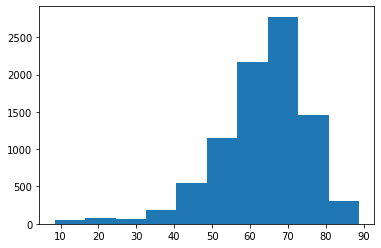

In [12]:
plt.hist(scaler_y.inverse_transform(prediction.reshape(-1, 1)).reshape(-1))

In [10]:
class TimeSeriesPlot:
    def __init__(self, df: pd.DataFrame, target_col:str, prediction_col:str, time_col:str="time"):
        self.df = df.copy(deep=True)
        self.target = target_col
        self.prediction = prediction_col
        self.time = time_col
        self.df['year'] = self.df[self.time].dt.year
        self.df['month'] = self.df[self.time].dt.month
        self.df['day'] = self.df[self.time].dt.day
        self.df['hours'] = self.df[self.time].dt.hour
        self.df["dayofweek"] = self.df[self.time].dt.weekday
        self.df["se"] = self.squared_error()
        self.df["mae"] = self.absolute_error()
        self.df["mape"] = self.absolute_percentage_error()

    def mape(self):
        return self.df["mape"].mean()

    def mae(self):
        return self.df["mae"].mean()

    def rmse(self):
        return np.sqrt(mean_squared_error(self.df[self.target], self.df[self.prediction]))

    def squared_error(self):
        return np.power(np.subtract(self.df[self.target], self.df[self.prediction]), 2)

    def absolute_error(self):
        return np.abs(np.subtract(self.df[self.target], self.df[self.prediction]))

    def absolute_percentage_error(self):
        return np.abs(np.divide(np.subtract(self.df[self.target], self.df[self.prediction]), self.df[self.target])) * 100

    def plot_rmse_by_time(self, time:str):
        fig = plt.figure()
        col_map = {"y": "year", "m": "month", "d": "day", "h": "hours",  "wd": "dayofweek"}
        group_by_cols = [col_map[param] for param in time.split("%") if param in col_map.keys()]
        grouped = self.df.groupby(by=group_by_cols)
        mean = grouped["se"].mean()
        group_index = [str(index) for index in mean.index]
        plt.plot(group_index, np.sqrt(mean), label="rmse")
        return fig

    def plot_multiple(self, *cols: str):
        fig = plt.figure()
        for col in cols:
            plt.plot(self.df[self.time].values, self.df[col].values, alpha=0.5, label=col)
        plt.legend()
        plt.show()
        return fig

    def plot_target_by_time(self, time:str, *targets:str):
        col_map = {"y": "year", "m": "month", "d": "day", "h": "hours",  "wd": "dayofweek"}
        group_by_cols = [col_map[param] for param in time.split("%") if param in col_map.keys()]
        self.df.boxplot(column=[*targets], by=group_by_cols,
                        layout=(targets.__len__(), 1), rot=45, figsize=(50,40), grid=False)
        return plt.gcf()

    def plot_target_by_time_band(self, time:str, *targets:str, band:bool=True):
        fig = plt.figure()
        col_map = {"y": "year", "m": "month", "d": "day", "h": "hours",  "wd": "dayofweek"}
        group_by_cols = [col_map[param] for param in time.split("%") if param in col_map.keys()]
        grouped = self.df.groupby(by=group_by_cols)
        for tar in targets:
            mean = grouped[tar].mean()
            std = grouped[tar].std()
            group_index = [str(index) for index in mean.index]
            plt.plot(group_index, mean, label=tar)
            if band:
                plt.fill_between(group_index, mean - 2*std, mean + 2*std, alpha=.5)
        plt.legend()
        return fig

In [53]:
#prediction_df = test_data.assign(prediction=scaler_y.inverse_transform(prediction.reshape(-1, 1)).reshape(-1)).reset_index()
#prediction_df = test_data.assign(prediction=test_data["price"].shift(1)).dropna().reset_index()
prediction_df.head()

,time,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,load,price,prediction
0,2018-01-01 00:00:00+00:00,283.628,1026.6,60.0,3.2,236.6,0.0,0.0,0.0,4.0,22009.0,4.74,-0.284854
1,2018-01-01 01:00:00+00:00,283.170,1027.0,68.0,3.6,160.0,0.0,0.0,0.0,0.0,20589.0,-0.83,-0.406642
2,2018-01-01 02:00:00+00:00,282.432,1027.4,76.2,3.6,168.0,0.0,0.0,0.0,0.0,19547.0,3.48,-0.715235
3,2018-01-01 03:00:00+00:00,281.988,1027.8,71.0,4.2,212.0,0.0,0.0,0.0,4.0,18871.0,-9.13,-0.497304
4,2018-01-01 04:00:00+00:00,281.710,1028.2,63.6,3.6,184.0,0.0,0.0,0.0,1.6,18688.0,4.05,-0.766037


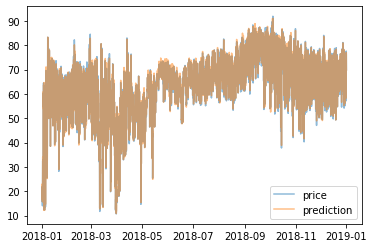

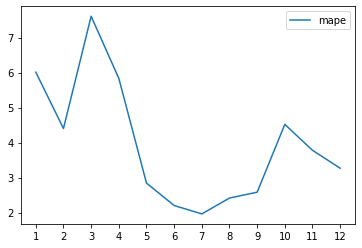

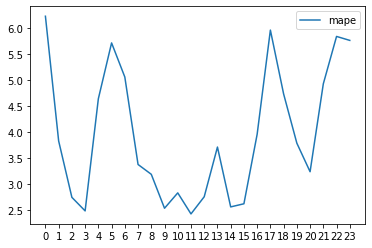

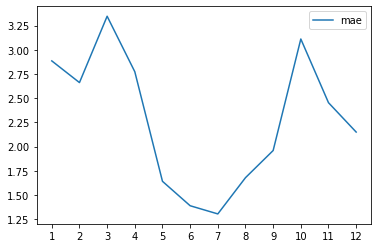

In [196]:
foobar = TimeSeriesPlot(prediction_df, "price", "prediction")
fig = foobar.plot_multiple("price", "prediction")
#fig.savefig("results/actual_prediction.png")
#bp = foobar.plot_target_by_time("%m%wd", "price", "prediction")
#bp.savefig("results/foo.png")
band = foobar.plot_target_by_time_band("%m", "mape", band=False)
#band.savefig("results/mape_per_month.png")
band = foobar.plot_target_by_time_band("%h", "mape", band=False)
#band.savefig("results/mape_per_hour.png")
band = foobar.plot_target_by_time_band("%m", "mae", band=False)
#band.savefig("results/mae_per_hour.png")
#rmse = foobar.plot_rmse_by_time("%m")
#band.savefig("results/band.png")

In [189]:
print("rmse: %f" % foobar.rmse())
print("mape: %f" % foobar.mape())
print("mae: %f" % foobar.mae())

rmse: 3.258205
mape: 4.224648
mae: 2.277323


In [192]:
# undiff
start, x_diff = 19.020, prediction_df["price"].iloc[1:]
prediction_df["price"] = np.r_[start, x_diff].cumsum().astype(float)

start, x_diff = 19.020, prediction_df["prediction"].iloc[1:]
prediction_df["prediction"] = np.r_[start, x_diff].cumsum().astype(float)

In [195]:
# undiff 2
prediction_df["prediction"] = prediction_df["prediction"].add(data["price_"].iloc[26304:-1].reset_index(drop=True))
prediction_df["price"] = prediction_df["price"].add(data["price_"].iloc[26304:-1].reset_index(drop=True))

In [12]:
stats = []
for f_o in tqdm(range(24*7-1)):
    prediction_df = test_data[f_o:prediction.shape[0]+f_o].assign(prediction=prediction[:,f_o]).reset_index()
    foobar = TimeSeriesPlot(prediction_df, "price", "prediction")
    stats.append([foobar.rmse(), foobar.mape(), foobar.mae()])
df_stats = pd.DataFrame(stats, columns=["rmse", "mape", "mae"])
df_stats

100%|██████████| 167/167 [00:02<00:00, 78.52it/s]


,rmse,mape,mae
0,3.189002,4.255014,2.391294
1,4.291371,5.784089,3.242667
2,5.111129,6.968672,3.877379
3,5.675136,7.817581,4.313581
4,6.060710,8.407624,4.604105
...,...,...,...
162,13.802162,19.586781,10.515777
163,13.781531,19.611956,10.520652
164,13.761039,19.631867,10.522544
165,13.741860,19.633991,10.518026


In [13]:
df_stats.iloc[23]

rmse     8.005513
mape    11.267736
mae      5.987516
Name: 23, dtype: float64

In [ ]:
df_stats.plot()

In [113]:
for i in range(prediction.shape[0]):
    for j in range(prediction.shape[1]):
        #.cpu().numpy()
        prediction[i][j] = prediction[i][j][0][0]

In [111]:
for i in range(prediction.shape[0]):
    for j in range(prediction.shape[1]):
        prediction[i][j] = scaler_y.inverse_transform(prediction[i][j].reshape(1, -1))

In [11]:
prediction = np.loadtxt(os.path.join(DATA_PATH, "predictions_inversed.csv"))

In [115]:
np.savetxt(os.path.join(DATA_PATH, "predictions_inversed.csv"), prediction)
